In [2]:
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import mean_absolute_error
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

# Funções

In [3]:
def correct_apac(df_in):
    df_apac = df_in
    df_apac = df_apac[df_apac.dia != "dia"]
    
    df_apac['Datetime']=pd.to_datetime(df_apac.dia.apply(str)+"/"+df_apac.mes.apply(str)+"/"+\
                                       df_apac.ano.apply(str), format="%d/%b/%Y")+\
                                       df_apac['hora(utc)'].apply(lambda x: datetime.timedelta(hours=int(x)))
    
    df_apac.drop(['ano','mes', 'dia', 'hora(utc)'],inplace=True,axis = 1)# drop duplicate infomation
    df_apac.drop_duplicates(subset="Datetime", inplace=True)
    
    inicio = datetime.datetime.strptime("01/"+str(df_apac.Datetime.iloc[0].month)+"/"+\
            str(df_apac.Datetime.iloc[0].year) + " "+ str(datetime.timedelta(hours=0)), "%d/%m/%Y %H:%M:%S")
    
    fim = df_apac.Datetime.iloc[-1]
    idx = pd.date_range(start=inicio,end=fim,freq='1H')
    
    #print(len(df_apac), len(df_apac.Datetime.unique()))
    
    df_apac = df_apac.set_index('Datetime').reindex(idx).reset_index().fillna(method='ffill')
        
    return df_apac

def correct_inmet(df_in):
    df_inmet = df_in
    df_inmet.replace('////', np.nan, inplace=True)
    
    columns_to_numeric = list(set(df_inmet.columns) - set(["codigo_estacao","data","hora","planta"]))
    
    df_inmet[columns_to_numeric] = df_inmet[columns_to_numeric].apply(pd.to_numeric)
    df_inmet['Datetime']=pd.to_datetime(df_inmet.data, format="%d/%m/%Y")\
                    +df_inmet.hora.apply(lambda x: datetime.timedelta(hours=x))

    df_inmet.drop(['data','hora'],inplace=True,axis = 1)# drop duplicate infomation
    inicio = datetime.datetime.strptime("01/"+str(df_inmet.Datetime.iloc[0].month)+"/"+\
            str(df_inmet.Datetime.iloc[0].year) + " "+ str(datetime.timedelta(hours=0)), "%d/%m/%Y %H:%M:%S")
        
    fim = df_inmet.Datetime.iloc[-1]
    idx = pd.date_range(start=inicio,end=fim,freq='1H')
    df_inmet = df_inmet.set_index('Datetime').reindex(idx).reset_index().fillna(method='ffill')
     
    return df_inmet

def autolabel(rects, ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,'%d' % int(height),
                ha='center', va='bottom')
        
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / (y_true+0.01))) * 100  

def mybinconfusionmatrix(y_true, y_pred):
    """        Y_t
              0    1
        p  0  vn  fn
        |   
        Y  1  fp  vp
    """
    confMatrix = np.zeros((2,2))
    vp = 0
    vn = 0
    fp = 0
    fn = 0
    
    for i in range(len(y_true)):
        if y_true[i] == 1 and y_pred[i]== 1:
            vp+=1
        if y_true[i] == 1 and y_pred[i]== 0:
            fn+=1
        if y_true[i] == 0 and y_pred[i]== 1:
            fp+=1
        if y_true[i] == 0 and y_pred[i]== 0:
            vn+=1
            
    if vn+fn != 0:
        confMatrix[0,0]=vn/(vn+fn)
        confMatrix[0,1]=fn/(vn+fn)
        
    if vp+fp != 0:
        confMatrix[1,0]=fp/(vp+fp)
        confMatrix[1,1]=vp/(vp+fp)
            
    return confMatrix
            
def indices_performances(y_true, y_pred, thresh=5):
    """y_true - true values\n
    y_pred- predicted valeus\n
    thresh- threshold for binarization
    """
    y_true[y_true>thresh] = 1
    y_true[y_true<thresh] = 0
    
    y_pred[y_pred>thresh] = 1
    y_pred[y_pred<thresh] = 0
    
    M = mybinconfusionmatrix(y_true, y_pred)
    output = {}
    
    a = M[1,1]
    b = M[1,0]
    c = M[0,1]
    d = M[0,0]
    
    if a+b+c+d != 0:
        output["PC"] = (a+d)/(a+b+c+d)
        output["FPR"] = (c+b)/(a+b+c+d)
    else:
        output["PC"] = 0
    if a+c != 0:
        output["POD"] = a/(a+c)
        output["BIAS"] = (a+b)/(a+c)
    else:
        output["POD"] = 0
        output["BIAS"] = 0
    if a+b != 0:
        output["FAR"] = b/(a+b)
    else:
        output["FAR"] = 0
    if a+b+c != 0:
        output["CSI"] = a/(a+b+c)
    else:
        output["CSI"] = 0
    
    
    return output

In [4]:
def plot_and_save_corr_mae_per_variable(df_apac, df_inmet, save_folder, Dict_map_cidades_apac_inmet, 
                                 Dict_map_columns_apac_inmet, qt_days_prv):

    for apac_variable in Dict_map_columns_apac_inmet.keys():
        pearson_corr = []
        maes = []
        inmet_variable = Dict_map_columns_apac_inmet[apac_variable]
        #print(apac_variable)
        
        for apac_point in Dict_map_cidades_apac_inmet.keys():
            #print(apac_point)
            
            inmet_point = Dict_map_cidades_apac_inmet[apac_point]
            
            df_apac = correct_apac(df_apac_total[
                (df_apac_total.planta==apac_point) & (df_apac_total.diasprev == qt_days_prv)])

            df_inmet = correct_inmet(df_inmet_total[df_inmet_total.planta==inmet_point])

            inmet_values = df_inmet.loc[:, inmet_variable].fillna(
                df_inmet[inmet_variable].mean()).astype('float32').values
            
            apac_values = df_apac.loc[:df_inmet.index[-1],:][apac_variable].fillna(
                df_apac.loc[:df_inmet.index[-1],:][apac_variable].mean()).astype('float32').values
            
            
            apac_values = np.nan_to_num(apac_values)
            inmet_values = np.nan_to_num(inmet_values)
            
            corr, twotailed = pearsonr(apac_values, inmet_values)
            maes.append(mean_absolute_error(inmet_values, apac_values))

            pearson_corr.append(corr)
    
        fig, ax1 = plt.subplots(figsize=(16,10))
        
        plt.grid(True, axis="y")

        ax1.set_title(apac_variable, fontsize=18)

        color = 'k'
        tkw = dict(size=6, width=2)
        ax1.set_xlabel('Measurement Points', color=color, fontsize=16)
        ax1.set_ylabel('Correlation', color=color, fontsize=16)
        ax1.bar(Dict_map_cidades_apac_inmet.keys(), pearson_corr, width=0.5, color=color, align='center')
        ax1.tick_params(axis='y', labelcolor='k', **tkw)
        
        min_cor=np.floor(min(pearson_corr))
        max_cor=np.ceil(max(pearson_corr))
        Amp_cor=max(pearson_corr) - min(pearson_corr)
        
        ax1.set_yticks(np.arange(min_cor, max_cor+Amp_cor/5, Amp_cor/5))
        plt.xticks(rotation=45)
        
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'r'
        ax2.set_ylabel('MAE', color=color, fontsize=16)  # we already handled the x-label with ax1
        ax2.scatter(Dict_map_cidades_apac_inmet.keys(), maes, color=color)
        ax2.tick_params(axis='y', labelcolor=color, **tkw)
        
        min_maes=np.floor(min(maes))
        max_maes=np.ceil(max(maes))
        Amp_maes=max(maes) - min(maes)
        
        ax2.set_yticks(np.arange(min_maes, max_maes+Amp_maes/5, Amp_maes/5))
        
        savename = save_folder + '\\'+'correlation_mae_'+apac_variable+ "_"+ str(qt_days_prv)+'.png'

        plt.savefig(savename, dpi=300)

In [5]:
def plot_analise_chuva(df_apac, df_inmet, save_folder, Dict_map_cidades_apac_inmet, 
                                 map_chuva, qt_days_prv, freq="1D", tresh=5):
    """
    freq = ["ND" - N<30] or None
    """
    
    def make_patch_spines_invisible(ax):
            ax.set_frame_on(True)
            ax.patch.set_visible(False)
            for sp in ax.spines.values():
                sp.set_visible(False)
    
    for apac_variable in map_chuva.keys():
        performances = []
        inmet_variable = map_chuva[apac_variable]
        #print(apac_variable)
        
        apac_points = Dict_map_cidades_apac_inmet.keys()
        
        for apac_point in apac_points:
            #print(apac_point)
            inmet_point = Dict_map_cidades_apac_inmet[apac_point]

            df_apac = correct_apac(df_apac_total[
                (df_apac_total.planta==apac_point) & (df_apac_total.diasprev == qt_days_prv)])

            df_inmet = correct_inmet(df_inmet_total[df_inmet_total.planta==inmet_point])
            
            if freq == None:
                inmet_values = df_inmet.loc[:, inmet_variable].fillna(
                    df_inmet[inmet_variable].mean()).astype('float32').values

                apac_values = df_apac.loc[:df_inmet.index[-1],:][apac_variable].fillna(
                    df_apac.loc[:df_inmet.index[-1],:][apac_variable].mean()).astype('float32').values
            
            else:
                grouped_inmet = df_inmet.groupby(pd.Grouper(key='index', freq=freq)).sum()
                inmet_values = grouped_inmet.loc[:,inmet_variable].values
                grouped_apac = df_apac.groupby(pd.Grouper(key='index', freq=freq)).sum()
                apac_values = grouped_apac.loc[:grouped_inmet.index[-1],apac_variable].values
            
            apac_values = np.nan_to_num(apac_values)
            inmet_values = np.nan_to_num(inmet_values)
            
            performance = indices_performances(apac_values, inmet_values, 1)
            performances.append(performance)
        
        
        # Sorting by PC
        
        PC = np.array(list(map(lambda d: d["PC"], performances)))
        argsort = PC.argsort()
        PC = PC[argsort]
        POD = np.array(list(map(lambda d: d["POD"], performances)))[argsort]
        FAR = np.array(list(map(lambda d: d["FAR"], performances)))[argsort]
        CSI = np.array(list(map(lambda d: d["CSI"], performances)))[argsort]
        BIAS = np.array(list(map(lambda d: d["BIAS"], performances)))[argsort]
        xlabels = np.array(list(apac_points))[argsort]
        
        fig, host = plt.subplots(figsize=(20,15))
        
        # Metricas de performance
        #################################################
        host.set_title("Perfomance Chuva", fontsize=20)

        par1 = host.twinx()
        par2 = host.twinx()
        par3 = host.twinx()
        par4 = host.twinx()

        # Offset the right spine of par2.  The ticks and label have already been
        # placed on the right by twinx above.
        par2.spines["right"].set_position(("axes", 1.07))
        par3.spines["right"].set_position(("axes", 1.14))
        par4.spines["right"].set_position(("axes", 1.21))
        # Having been created by twinx, par2 has its frame off, so the line of its
        # detached spine is invisible.  First, activate the frame but make the patch
        # and spines invisible.
        make_patch_spines_invisible(par2)
        make_patch_spines_invisible(par3)
        make_patch_spines_invisible(par4)
        # Second, show the right spine.
        par2.spines["right"].set_visible(True)
        par3.spines["right"].set_visible(True)
        par4.spines["right"].set_visible(True)
        
        colors=["b","r","g","k","m"]
        
        p1, = host.plot(xlabels, PC, c=colors[0], linewidth=3, marker="*", markersize=15, label="PC")
        p2, = par1.plot(xlabels, POD, c=colors[1], linewidth=3, marker=".", markersize=15, label="POD")
        p3, = par2.plot(xlabels, FAR, c=colors[2], linewidth=3, marker="P", markersize=15, label="FAR")
        p4, = par3.plot(xlabels, CSI, c=colors[3], linewidth=3, marker="<", markersize=15, label="CSI")
        p5, = par4.plot(xlabels, BIAS, c=colors[4], linewidth=3, marker="d", markersize=15, label="BIAS")

        host.set_xlabel("Measurement Points", fontsize=16)
        host.set_ylabel("Proporção Correta", fontsize=16)
        par1.set_ylabel("Probabilidade de Detecção", fontsize=16)
        par2.set_ylabel("Taxa de Alarme Falso", fontsize=16)
        par3.set_ylabel("Índice de Sucesso Crítico", fontsize=16)
        par4.set_ylabel("Taxa de Tendência", fontsize=16)

        host.yaxis.label.set_color(colors[0])
        par1.yaxis.label.set_color(colors[1])
        par2.yaxis.label.set_color(colors[2])
        par3.yaxis.label.set_color(colors[3])
        par4.yaxis.label.set_color(colors[4])

        tkw = dict(size=14, width=2, labelsize=16)
        host.tick_params(axis='y', colors=colors[0], **tkw)
        par1.tick_params(axis='y', colors=colors[1], **tkw)
        par2.tick_params(axis='y', colors=colors[2], **tkw)
        par3.tick_params(axis='y', colors=colors[3], **tkw)
        par4.tick_params(axis='y', colors=colors[4], **tkw)
        host.tick_params(axis='x', rotation=45, **tkw)
        
        host.grid(True, axis="both")
        
        lines = [p1, p2, p3, p4, p5]

        host.legend(lines, [l.get_label() for l in lines], fontsize=16, loc="upper left")
        savename = save_folder + '\\'+'performance_'+apac_variable+ "_"+ str(qt_days_prv)+'.png'
        plt.savefig(savename, dpi=300, bbox_inches='tight')

# Métricas

## Variáveis

In [6]:
Dict_map_cidades_apac_inmet = {"Coremas":"coremas","Aquiraz":"aquiraz","Assu":"assu","Barreiras":"barreiras",
                               "BJLapaI":"bomjesusdalapa","BJLapaII":"bomjesusdalapa",
                                "BJLapaIII":"bomjesusdalapa","BJLapaIV":"bomjesusdalapa",
                                "Juazeiro":"juazeiro","Mossoro":"mossoro","Quixere":"quixere",
                                "SGGurgeia":"sggurgeias","SJPiaui":"sjpiaui","TabocasI":"tabocas",
                                "TabocasII":"tabocas","Tacaratu":"tacaratu", "Petrolina":"tacaratu",
                              "Arco_Verde":"arcoverde","Cabrobo":"cabrobo", "Floresta":"floresta",
                               "Garanhuns":"garanhuns","Ibimirim":"ibimirim","Recife":"recife","Salgueiro":"salgueiro",
                              "Surubim":"surubim","Palmares":"palmares", "Ouricuri":"ouricuri",
                               "Serra_Talhada":"serratalhada"}

map_columns_apac_inmet_corr_mae = {"temperatura":"temp_inst","umidade":"umid_inst","pontodeorvalho":"pto_orvalho_inst",
                                "pressao":"pressao","VVel":"vento_vel","Vdir":"vento_direcao",
                                "Irradiacao":"radiacao"}

map_chuva = {"chuva":"precipitacao"}

qt_days_prv = 1

## Abril

In [8]:
apac_csv = '.\APAC_Data\Abril_WRF_APAC.csv'
inmet_csv = '.\INMET_Data\Abril_INMET.csv'

save_folder = "metrics/abril"

df_apac_total = pd.read_csv(apac_csv, sep=';', encoding = "ISO-8859-1")
df_inmet_total = pd.read_csv(inmet_csv, sep=',', encoding = "ISO-8859-1")

os.makedirs(save_folder, exist_ok=True)

# plot_and_save_corr_mae_per_variable(df_apac_total, df_inmet_total, save_folder, Dict_map_cidades_apac_inmet,
#                              map_columns_apac_inmet_corr_mae, qt_days_prv)

# plot_analise_chuva(df_apac_total, df_inmet_total, save_folder, Dict_map_cidades_apac_inmet,
#                    map_chuva, qt_days_prv,freq="1D", tresh=5)

## Maio

In [41]:
apac_csv = '.\APAC_Data\Maio_WRF_APAC.csv'
inmet_csv = '.\INMET_Data\Maio_INMET.csv'

save_folder = "metrics/maio"

df_apac_maio = pd.read_csv(apac_csv, sep=';', encoding = "ISO-8859-1")
df_inmet_maio = pd.read_csv(inmet_csv, sep=',', encoding = "ISO-8859-1")

os.makedirs(save_folder, exist_ok=True)


# plot_and_save_corr_mae_per_variable(df_apac_maio, df_inmet_maio, save_folder, Dict_map_cidades_apac_inmet,
#                              map_columns_apac_inmet_corr_mae, qt_days_prv)

# plot_analise_chuva(df_apac_maio, df_inmet_maio, save_folder, Dict_map_cidades_apac_inmet,
#                    map_chuva, qt_days_prv,freq="1D", tresh=5)

# Todos os Meses

In [59]:
apac_csvs = ['.\APAC_Data\Abril_WRF_APAC.csv', '.\APAC_Data\Maio_WRF_APAC.csv']
inmet_csvs = ['.\INMET_Data\Abril_INMET.csv','.\INMET_Data\Maio_INMET.csv']

save_folder = "metrics/all"

os.makedirs(save_folder, exist_ok=True)

df_apac_total = pd.read_csv(apac_csvs[0], sep=';', encoding = "ISO-8859-1")
df_inmet_total = pd.read_csv(inmet_csvs[0], sep=',', encoding = "ISO-8859-1")

for dfs_count in range(1, len(apac_csvs)):
    df_apac_total = df_apac_total.append(pd.read_csv(apac_csvs[dfs_count], sep=';', encoding = "ISO-8859-1"))
    df_inmet_total = df_inmet_total.append(pd.read_csv(inmet_csvs[dfs_count], sep=';', encoding = "ISO-8859-1"))    

#plot_and_save_corr_mae_per_variable(df_apac_total, df_inmet_total, save_folder, Dict_map_cidades_apac_inmet,map_columns_apac_inmet_corr_mae, qt_days_prv)

#plot_analise_chuva(df_apac_total, df_inmet_total, save_folder, Dict_map_cidades_apac_inmet,map_chuva, qt_days_prv, freq="1D", tresh=5)

In [61]:
df_inmet_total[df_inmet_total.planta==inmet_point].data

15480    01/04/2020
15481    01/04/2020
15482    01/04/2020
15483    01/04/2020
15484    01/04/2020
            ...    
16195    30/04/2020
16196    30/04/2020
16197    30/04/2020
16198    30/04/2020
16199    30/04/2020
Name: data, Length: 720, dtype: object

## Solar Radiation Forecast

### Preparando Dados

In [32]:
import sys
sys.path.append("../")
from mlopt.mlopt.TimeSeriesUtils import train_test_split, SMAPE, MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

apac_point="Petrolina"

inmet_point = Dict_map_cidades_apac_inmet[apac_point]

df_apac = correct_apac(df_apac_total[(df_apac_total.planta==apac_point) & (df_apac_total.diasprev == qt_days_prv)])

df_inmet = correct_inmet(df_inmet_total[df_inmet_total.planta==inmet_point])

y = df_inmet["radiacao"].values

y[y<0] = 0

max_power = max(y)
y = y/max_power
X_train, y_train, X_test, y_test = train_test_split(y, 24, tr_vd_ts_percents = [80, 20], print_shapes = True)

y_apac = df_apac['Irradiacao'].fillna("ffil").values
y_hat_apac = y_apac[-len(y_test):]/max(y_apac)

X_train:  (576, 24)
y_train:  (576, 1)
X_test:  (144, 24)
y_test:  (144, 1)


In [34]:
df_inmet

,index,planta,codigo_estacao,temp_inst,temp_max,temp_min,umid_inst,umid_max,umid_min,pto_orvalho_inst,...,pto_orvalho_min,pressao,pressao_max,pressao_min,vento_vel,vento_direcao,vento_rajada,radiacao,precipitacao,"planta,codigo_estacao,data,hora,temp_inst,temp_max,temp_min,umid_inst,umid_max,umid_min,pto_orvalho_inst,pto_orvalho_max,pto_orvalho_min,pressao,pressao_max,pressao_min,vento_vel,vento_direcao,vento_rajada,radiacao,precipitacao"
0,2020-04-01 00:00:00,tacaratu,A351,26.8,27.6,26.8,65,65,64,19.8,...,19.8,974.7,974.7,974.0,2.5,125.0,6.0,0.00,0.0,NaN
1,2020-04-01 01:00:00,tacaratu,A351,25.8,26.8,25.8,69,69,65,19.7,...,19.7,975.0,975.0,974.7,1.9,141.0,4.9,0.00,0.0,NaN
2,2020-04-01 02:00:00,tacaratu,A351,25.0,25.7,25.0,72,72,69,19.6,...,19.6,975.1,975.1,975.0,2.2,143.0,5.4,0.00,0.0,NaN
3,2020-04-01 03:00:00,tacaratu,A351,24.2,25.0,24.2,76,76,72,19.8,...,19.6,974.6,975.1,974.6,1.7,145.0,4.6,0.00,0.0,NaN
4,2020-04-01 04:00:00,tacaratu,A351,23.5,24.2,23.5,81,81,76,20.0,...,19.8,974.2,974.6,974.2,2.0,142.0,4.3,0.00,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,2020-04-30 19:00:00,tacaratu,A351,29.9,31.0,29.6,49,50,47,18.0,...,17.9,975.8,975.8,975.6,4.1,160.0,7.8,1220.00,0.0,NaN
716,2020-04-30 20:00:00,tacaratu,A351,28.7,29.9,28.7,52,52,49,17.9,...,17.8,976.1,976.1,975.8,3.3,160.0,7.5,348.00,0.0,NaN
717,2020-04-30 21:00:00,tacaratu,A351,27.5,28.7,27.5,56,56,52,18.0,...,17.8,976.3,976.4,976.1,2.2,160.0,7.0,20.58,0.0,NaN
718,2020-04-30 22:00:00,tacaratu,A351,26.7,27.5,26.7,62,62,56,18.7,...,18.0,977.1,977.1,976.3,1.6,141.0,5.0,0.00,0.0,NaN


In [33]:
df_apac

,index,planta,diasprev,temperatura,umidade,pontodeorvalho,pressao,VVel,Vdir,Irradiacao,chuva
0,2020-04-01 00:00:00,Petrolina,1,25.2,68,18.8,967.1,4.4,122,0,0
1,2020-04-01 01:00:00,Petrolina,1,23.9,82,19.9,966.8,2.2,116,0,0
2,2020-04-01 02:00:00,Petrolina,1,23.7,85,20.3,967.0,2.1,125,0,0
3,2020-04-01 03:00:00,Petrolina,1,23.6,86,20.4,967.5,2.6,120,0,0
4,2020-04-01 04:00:00,Petrolina,1,23.2,88,20.4,967.7,2.6,116,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1459,2020-05-31 19:00:00,Petrolina,1,25.8,62,18.0,969.5,5.5,126,532,0
1460,2020-05-31 20:00:00,Petrolina,1,25.6,64,18.1,970.7,5.3,132,142,0
1461,2020-05-31 21:00:00,Petrolina,1,25.1,66,18.2,971.2,4.4,136,0,0
1462,2020-05-31 22:00:00,Petrolina,1,24.8,69,18.3,971.2,4.2,145,0,0


In [14]:
print("Resultado Dados Teste!")
print("APAC")
print("MAE: ", MAE(y_test, y_hat_apac))
print("MSE: ", MSE(y_test, y_hat_apac))
print("SMAPE: ", SMAPE(y_test[:,0], y_hat_apac))
print("MAPE: ", MAPE(y_test[:,0], y_hat_apac, threshold=0.05))

Resultado Dados Teste!
APAC
MAE:  0.0710006820716688
MSE:  0.016675105994267192
SMAPE:  64.13916489436158
MAPE:  43.52440897067186


..\mlopt\mlopt\TimeSeriesUtils.py:27: RuntimeWarning: invalid value encountered in true_divide
  tmp = 2 * np.abs(F[mask_threshold] - A[mask_threshold]) / (np.abs(A[mask_threshold]) + np.abs(F[mask_threshold]))


### APAC + AG_MLP_VR

,index,planta,diasprev,temperatura,umidade,pontodeorvalho,pressao,VVel,Vdir,Irradiacao,chuva
0,2020-04-01 00:00:00,Petrolina,1,25.2,68,18.8,967.1,4.4,122,0,0
1,2020-04-01 01:00:00,Petrolina,1,23.9,82,19.9,966.8,2.2,116,0,0
2,2020-04-01 02:00:00,Petrolina,1,23.7,85,20.3,967.0,2.1,125,0,0
3,2020-04-01 03:00:00,Petrolina,1,23.6,86,20.4,967.5,2.6,120,0,0
4,2020-04-01 04:00:00,Petrolina,1,23.2,88,20.4,967.7,2.6,116,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1459,2020-05-31 19:00:00,Petrolina,1,25.8,62,18.0,969.5,5.5,126,532,0
1460,2020-05-31 20:00:00,Petrolina,1,25.6,64,18.1,970.7,5.3,132,142,0
1461,2020-05-31 21:00:00,Petrolina,1,25.1,66,18.2,971.2,4.4,136,0,0
1462,2020-05-31 22:00:00,Petrolina,1,24.8,69,18.3,971.2,4.2,145,0,0


In [ ]:
from mlopt.mlopt.AGMLP_VR_Residual import AGMLP_VR_Residual
from mlopt.mlopt.TimeSeriesUtils import train_test_split, train_test_split_prev, SMAPE, MAPE
import pickle

ag_mlp_vr_residual = AGMLP_VR_Residual(y[:,0], y_apac, num_epochs = 2, size_pop = 5,prob_mut=0.2, tr_ts_percents=(80,20)).search_best_model()

best_mlp_vr_residual = ag_mlp_vr_residual._best_of_all

pickle.dump(best_mlp_vr_residual, open('resultados/best_model_APACL.pckl', 'wb'))

In [ ]:
tr_ts_percents=[80,20]

gen = y[:]

#best = pickle.load(open('resultados/best_model_AGMLP_VR_RESIDUAL.pckl', 'rb'))

best = best_mlp_vr_residual

erro = gen - y_ets

data_train = gen[0:int(len(y_ets)*tr_ts_percents[0]/100)]
data_test = gen[int(len(y_ets)*tr_ts_percents[0]/100):]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best[0], tr_ts_percents)
erro_estimado = np.concatenate((best[-3].VR_predict(erro_train_entrada), best[-3].VR_predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_ets, best[1], tr_ts_percents)
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best[2], best[3], tr_ts_percents)

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best[-2].VR_predict(X_in_train), best[-2].VR_predict(X_in_test)])
y_estimado_all_vr_residual = y_estimado_all
y_estimado_so_test = best[-2].VR_predict(X_in_test)

len_dt = len(data_test)

print(best)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(MAE(y_estimado_so_test, data_test),best[7]))
print (MAE(y_estimado_so_test, data_test) ==  best[6])

print('Resultado Dados Teste!')
print('HIBRIDO')
print('MAE: ', MAE(y_test, y_estimado_so_test[-len_dt:]))
print('MSE: ', MSE(y_test, y_estimado_so_test[-len_dt:]))
print('MAPE: ', MAPE(y_test[:,0], y_estimado_so_test[-len_dt:], threshold=0.05))
print('SMAPE: ', SMAPE(y_test[:,0], y_estimado_so_test[-len_dt:], threshold=0.05))

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_so_test, 'k--', label='y_hat_hibrid')
plt.plot(gen[-len_dt:], 'r', label='real')
plt.plot(y_ets[-len_dt:].values, 'g--', label='ETS')
plt.grid(axis='x')
plt.legend()

### ETS on INMET

In [85]:
from statsmodels.tsa.api import ExponentialSmoothing

In [86]:
y_pos = y + 0.0001
y_pos = pd.Series(y_pos)

fit1 = ExponentialSmoothing(y_pos, seasonal_periods=24, trend="add", seasonal="add",use_boxcox=False,initialization_method="estimated").fit()
fit2 = ExponentialSmoothing(y_pos,seasonal_periods=24,trend="add",seasonal="mul",use_boxcox=False,initialization_method="estimated").fit()
fit3 = ExponentialSmoothing(y_pos,seasonal_periods=24,trend="add",seasonal="add",damped_trend=True,use_boxcox=False,initialization_method="estimated",).fit()
fit4 = ExponentialSmoothing(y_pos,seasonal_periods=24,trend="add",seasonal="mul",damped_trend=True,use_boxcox=False,initialization_method="estimated").fit()
results = pd.DataFrame(index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$", r"$l_0$", "$b_0$", "SSE (SUM OF SQUARED ERRORS)"])
params = ["smoothing_level","smoothing_trend","damping_trend","smoothing_seasonal","initial_level","initial_trend"]

C:\Users\hugow\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\hugow\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


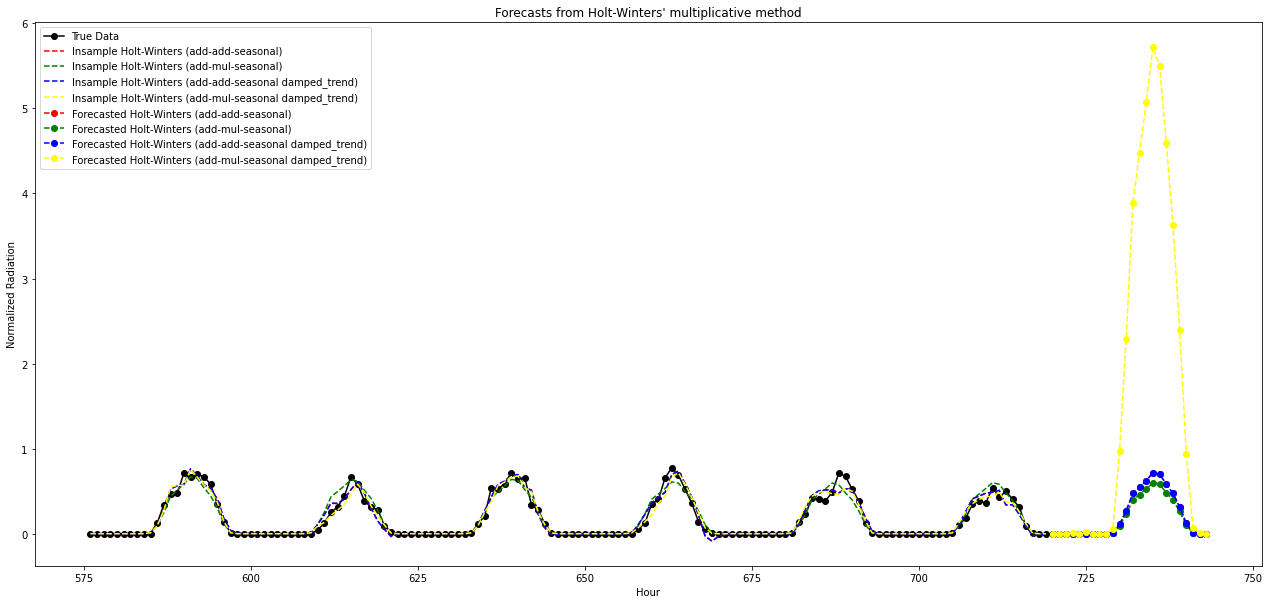

,Additive,Multiplicative,Additive Dam,Multiplicative Dam
$\alpha$,7.039117e-01,0.025127,7.017366e-01,0.700236
$\beta$,7.772278e-16,0.019439,5.435121e-16,0.000493
$\phi$,NaN,NaN,9.756038e-01,0.940862
$\gamma$,6.071287e-16,0.002518,2.050070e-15,0.000118
$l_0$,2.061535e-01,0.042807,2.067029e-01,0.073462
$b_0$,-4.852523e-05,-0.000211,-3.760456e-04,0.019240
SSE (SUM OF SQUARED ERRORS),3.842916e+00,3.765896,3.842890e+00,3.569202


In [87]:
results["Additive"] = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"] = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplicative Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

df_results_ets = pd.DataFrame()

df_results_ets["ets add-add"] = fit1.fittedvalues.values[-len(y_test):]
df_results_ets["ets add-mul"] = fit2.fittedvalues.values[-len(y_test):]
df_results_ets["ets add-add-dam"] = fit3.fittedvalues.values[-len(y_test):]
df_results_ets["ets add-mul-dam"] = fit4.fittedvalues.values[-len(y_test):]

ax = y_pos[-len(y_test):].plot(figsize=(22, 10),marker="o",label="True Data",color="black",title="Forecasts from Holt-Winters' multiplicative method",)
ax.set_ylabel("Normalized Radiation")
ax.set_xlabel("Hour")

fit1.fittedvalues[-len(y_test):].plot(ax=ax, style="--", color="red", label="Insample Holt-Winters (add-add-seasonal)")
fit2.fittedvalues[-len(y_test):].plot(ax=ax, style="--", color="green", label="Insample Holt-Winters (add-mul-seasonal)")
fit3.fittedvalues[-len(y_test):].plot(ax=ax, style="--", color="blue", label="Insample Holt-Winters (add-add-seasonal damped_trend)")
fit4.fittedvalues[-len(y_test):].plot(ax=ax, style="--", color="yellow", label="Insample Holt-Winters (add-mul-seasonal damped_trend)")

fit1.forecast(24).rename("Forecasted Holt-Winters (add-add-seasonal)").plot(ax=ax, style="--", marker="o", color="red", legend=True)
fit2.forecast(24).rename("Forecasted Holt-Winters (add-mul-seasonal)").plot(ax=ax, style="--", marker="o", color="green", legend=True)
fit3.forecast(24).rename("Forecasted Holt-Winters (add-add-seasonal damped_trend)").plot(ax=ax, style="--", marker="o", color="blue", legend=True)
fit4.forecast(24).rename("Forecasted Holt-Winters (add-mul-seasonal damped_trend)").plot(ax=ax, style="--", marker="o", color="yellow", legend=True)

plt.legend()
plt.show()
results

In [83]:
y_hat_ets = fit4.fittedvalues.values[-len(y_test):]

print("Resultado Dados Teste!")
print("ETS")
print("MAE: ", MAE(y_test, y_hat_ets))
print("MSE: ", MSE(y_test, y_hat_ets))
print("SMAPE: ", SMAPE(y_test[:,0], y_hat_ets))
print("MAPE: ", MAPE(y_test[:,0], y_hat_ets, threshold=0.05))

Resultado Dados Teste!
ETS
MAE:  0.030414372626643878
MSE:  0.003265874115351303
SMAPE:  106.65053681155386
MAPE:  18.02021603793307
Resultado Dados Teste!
APAC
MAE:  0.0710006820716688
MSE:  0.016675105994267192
SMAPE:  64.13916489436158
MAPE:  43.52440897067186


..\mlopt\mlopt\TimeSeriesUtils.py:27: RuntimeWarning: invalid value encountered in true_divide
  tmp = 2 * np.abs(F[mask_threshold] - A[mask_threshold]) / (np.abs(A[mask_threshold]) + np.abs(F[mask_threshold]))


2021-08-15 16:05:29,548 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-08-15 16:05:29,548: INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-08-15 16:05:29,562 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-08-15 16:05:29,562: INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-08-15 16:05:29,574 - matplotlib.category - INFO - Using categ

Text(0, 0.5, 'Normalized Power by 3884.0')

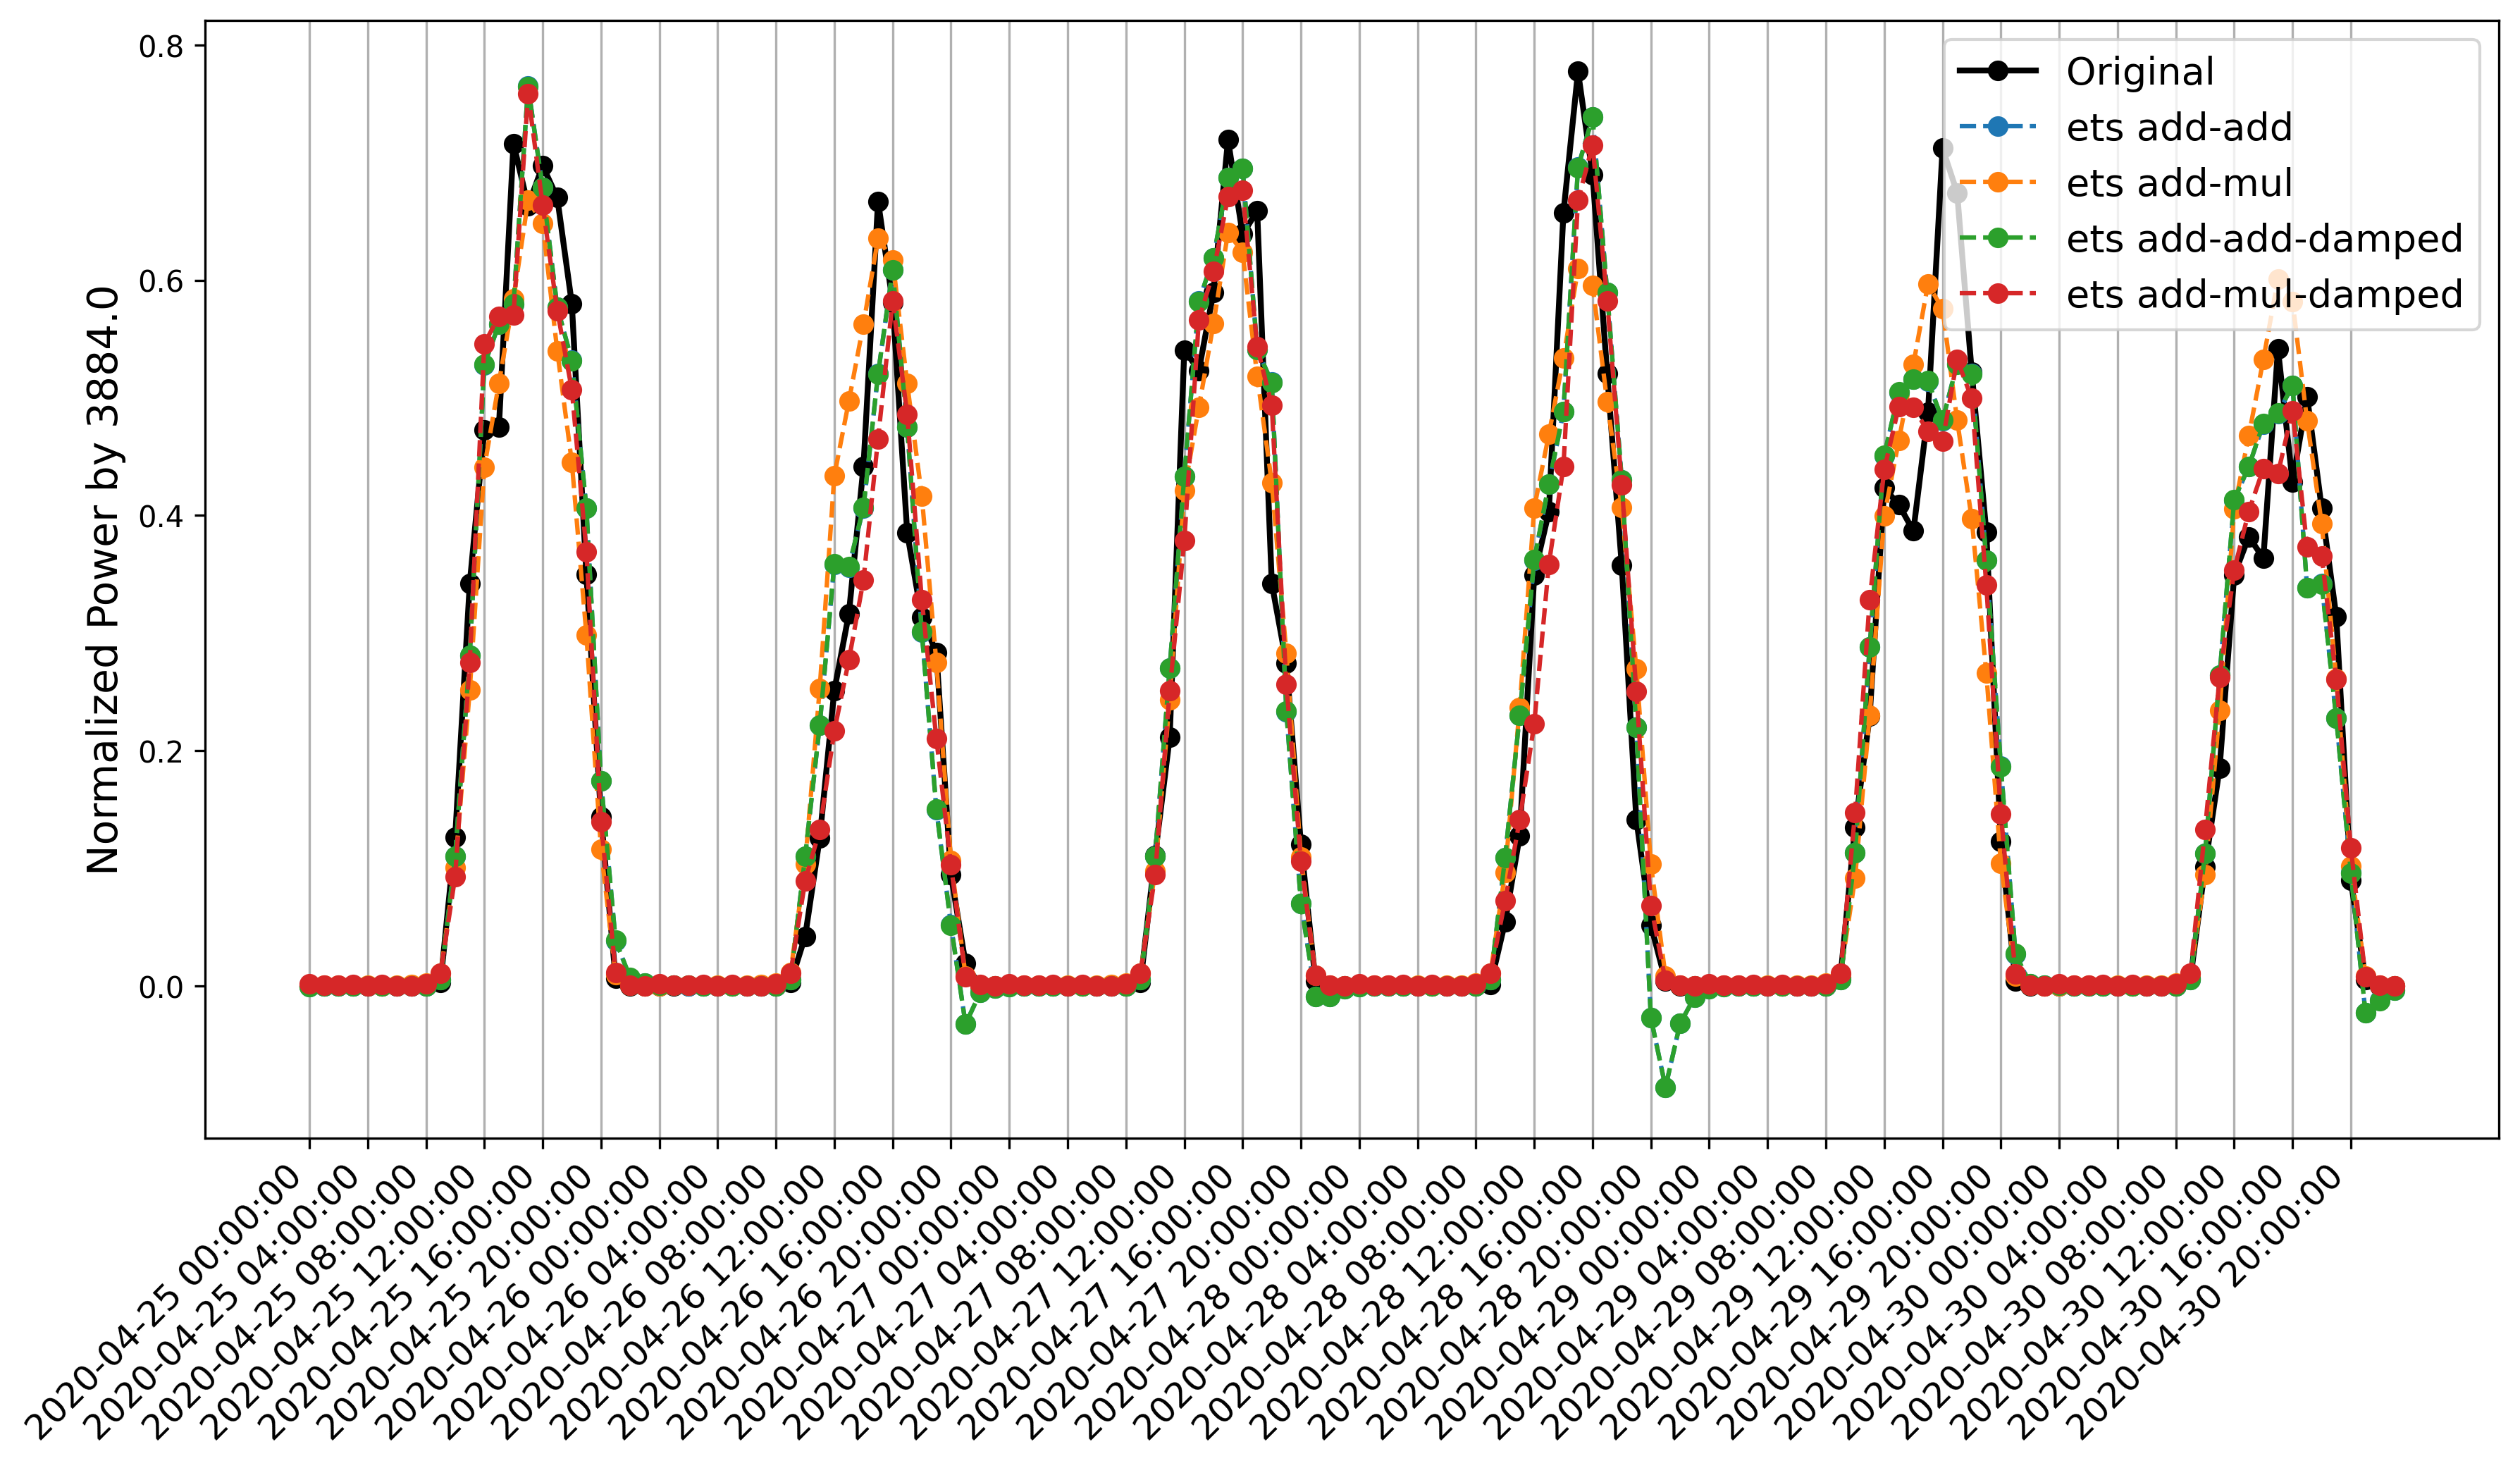

In [63]:
ticks_X = df_inmet["index"].astype('str')
len_dt = len(y_test)
ticks_X = ticks_X[-len_dt:].values

_, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

ax.plot(ticks_X, y_test, 'k-o', label='Original', linewidth=2.0)
ax.plot(ticks_X, df_results_ets["ets add-add"], '--o', label="ets add-add")
ax.plot(ticks_X, df_results_ets["ets add-mul"], '--o', label="ets add-mul")
ax.plot(ticks_X, df_results_ets["ets add-add-dam"], '--o', label="ets add-add-damped")
ax.plot(ticks_X, df_results_ets["ets add-mul-dam"], '--o', label="ets add-mul-damped")

plt.xticks(ticks_X[::4], rotation=45, ha='right', fontsize=12)
ax.grid(axis='x')
ax.legend(fontsize=13)
ax.set_ylabel('Normalized Power by {0}'.format(max_power), fontsize=14)

### ETS + AG_MLP_VR on INMET

In [99]:
from mlopt.mlopt.AGMLP_VR_Residual import AGMLP_VR_Residual
from mlopt.mlopt.TimeSeriesUtils import train_test_split, train_test_split_prev, SMAPE, MAPE
import pickle

#y_ets = fit4.fittedvalues

#ag_mlp_vr_residual = AGMLP_VR_Residual(y[:,0], y_ets, num_epochs = 2, size_pop = 5,prob_mut=0.2, tr_ts_percents=(80,20)).search_best_model()

#best_mlp_vr_residual = ag_mlp_vr_residual._best_of_all

#pickle.dump(best_mlp_vr_residual, open('resultados/best_model_AGMLP_VR_RESIDUAL.pckl', 'wb'))

[16, 19, 16, 8, 17, <mlopt.mlopt.AgMlp.AgMlp object at 0x0000024112F2DEB0>, <mlopt.mlopt.AgMlp.AgMlp object at 0x00000241131561F0>, 0.017783325616667692]
Teste para saber se pegou o melhor mesmo! 0.017783325616667692 == 0.017783325616667692 ?
False
Resultado Dados Teste!
HIBRIDO
MAE:  0.017783325616667692
MSE:  0.0011924807982091154
MAPE:  11.669072661172004
SMAPE:  11.982496148669785


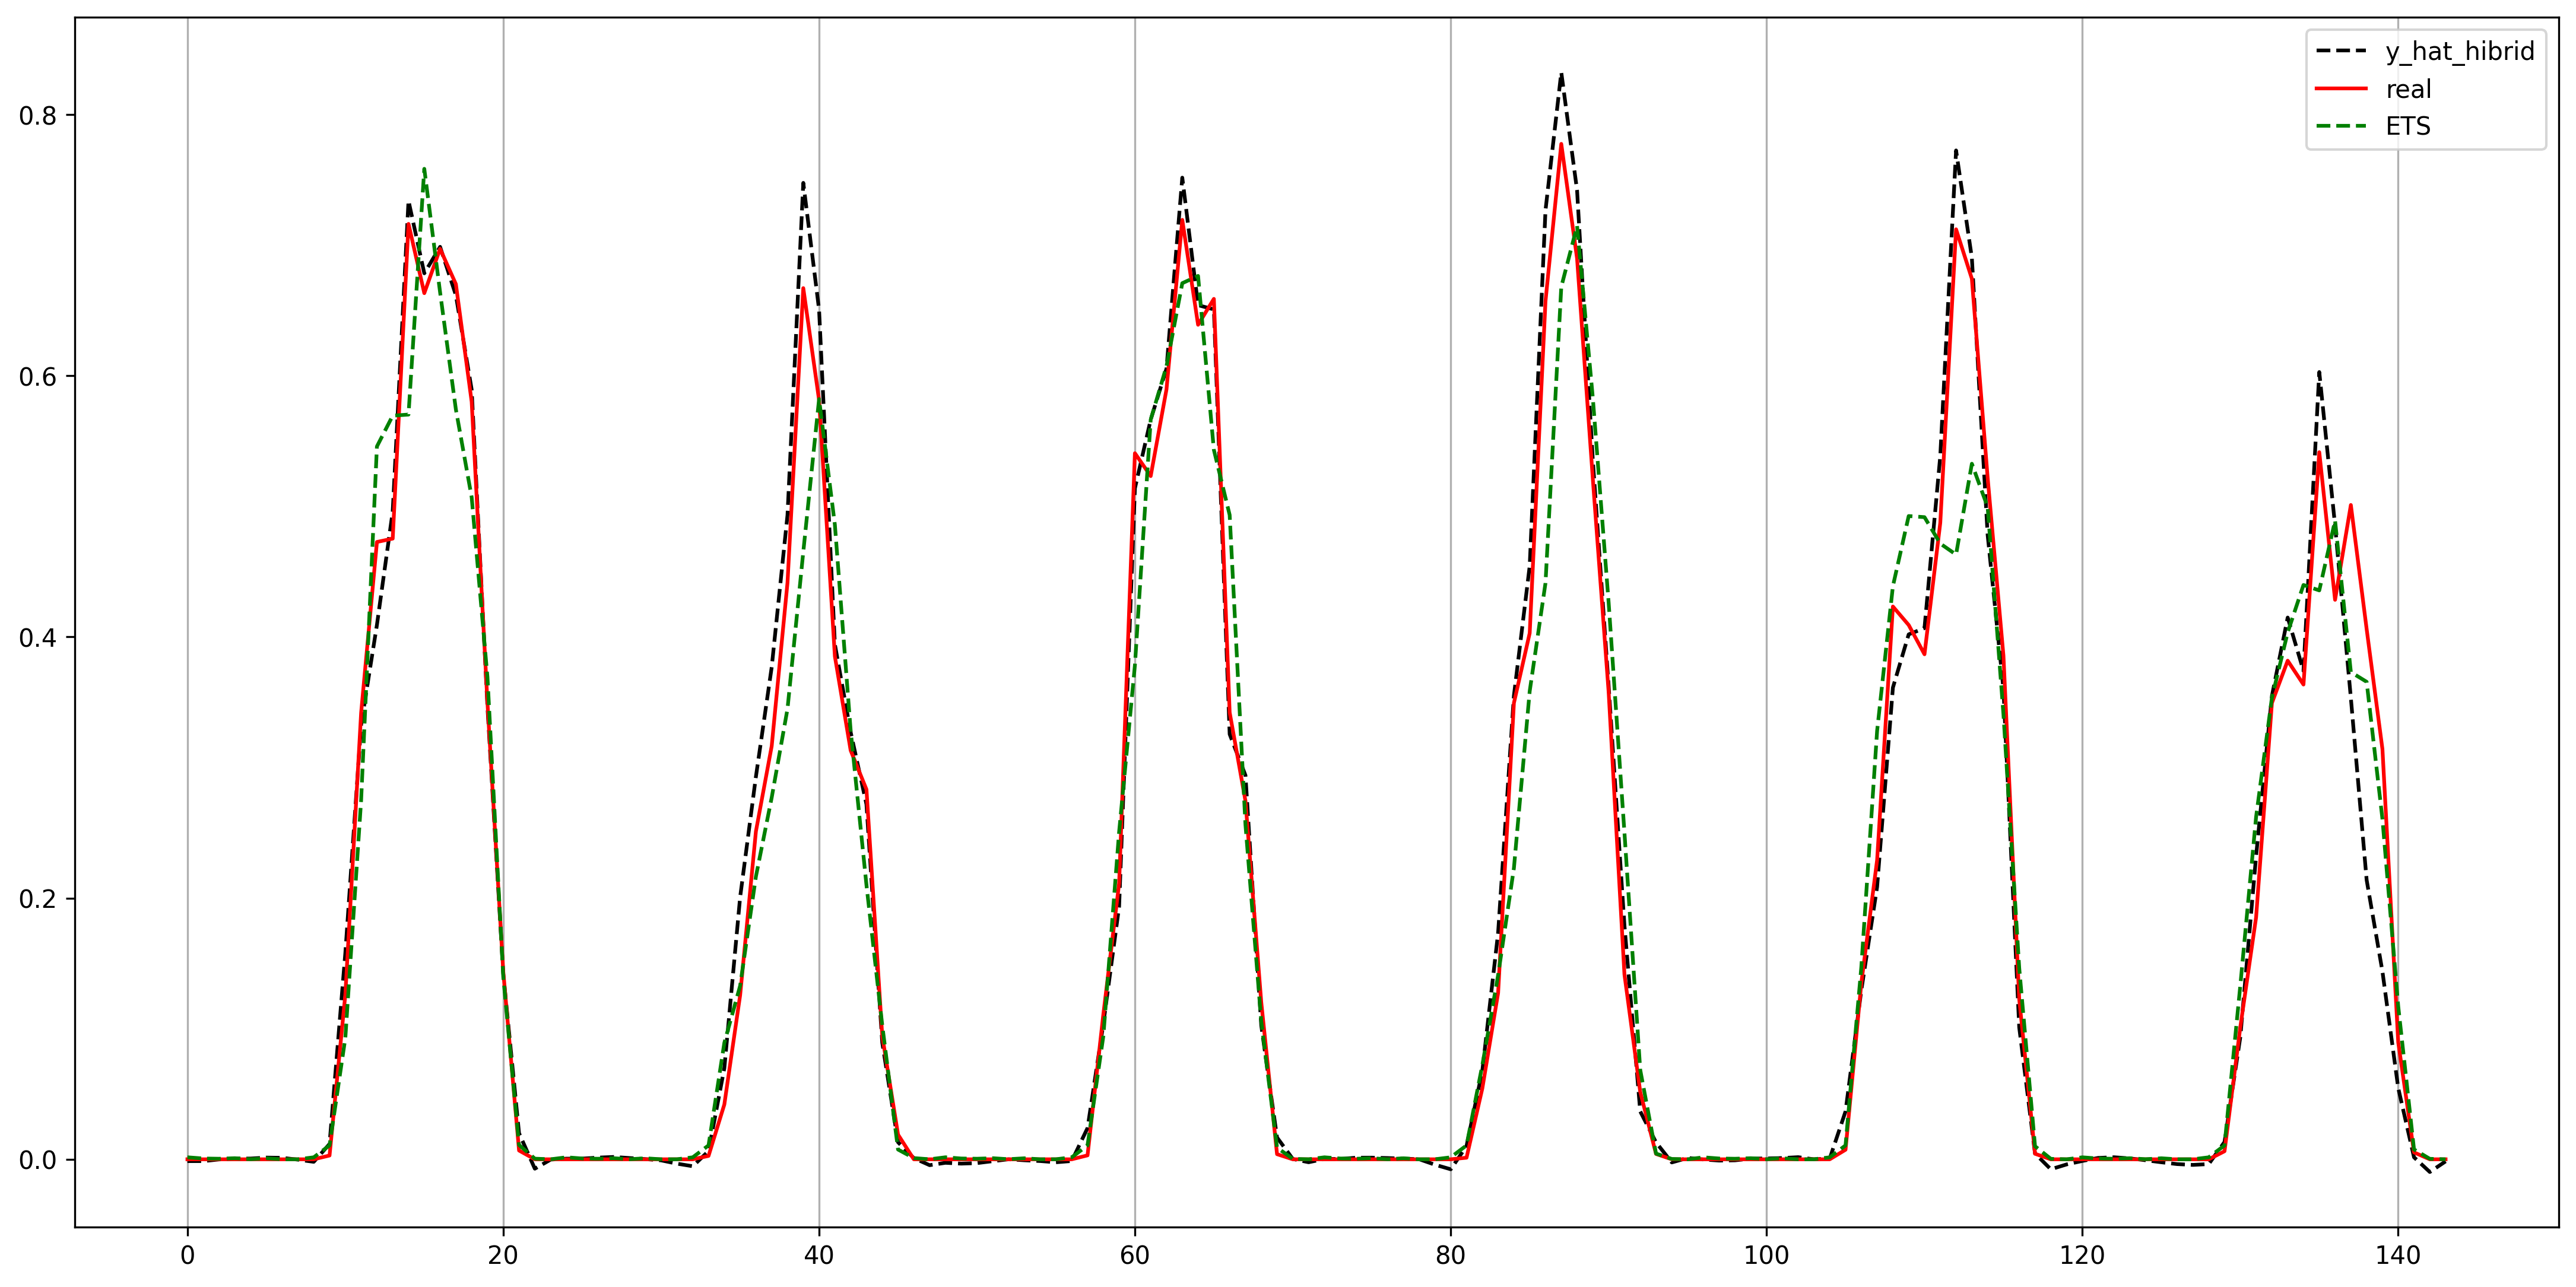

In [111]:
tr_ts_percents=[80,20]

gen = y[:]

#best = pickle.load(open('resultados/best_model_AGMLP_VR_RESIDUAL.pckl', 'rb'))

best = best_mlp_vr_residual

erro = gen - y_ets

data_train = gen[0:int(len(y_ets)*tr_ts_percents[0]/100)]
data_test = gen[int(len(y_ets)*tr_ts_percents[0]/100):]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best[0], tr_ts_percents)
erro_estimado = np.concatenate((best[-3].VR_predict(erro_train_entrada), best[-3].VR_predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_ets, best[1], tr_ts_percents)
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best[2], best[3], tr_ts_percents)

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best[-2].VR_predict(X_in_train), best[-2].VR_predict(X_in_test)])
y_estimado_all_vr_residual = y_estimado_all
y_estimado_so_test = best[-2].VR_predict(X_in_test)

len_dt = len(data_test)

print(best)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(MAE(y_estimado_so_test, data_test),best[7]))
print (MAE(y_estimado_so_test, data_test) ==  best[6])

print('Resultado Dados Teste!')
print('HIBRIDO')
print('MAE: ', MAE(y_test, y_estimado_so_test[-len_dt:]))
print('MSE: ', MSE(y_test, y_estimado_so_test[-len_dt:]))
print('MAPE: ', MAPE(y_test[:,0], y_estimado_so_test[-len_dt:], threshold=0.05))
print('SMAPE: ', SMAPE(y_test[:,0], y_estimado_so_test[-len_dt:], threshold=0.05))

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_so_test, 'k--', label='y_hat_hibrid')
plt.plot(gen[-len_dt:], 'r', label='real')
plt.plot(y_ets[-len_dt:].values, 'g--', label='ETS')
plt.grid(axis='x')
plt.legend()